In [67]:
import os
import re
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from MLPClassifierWithSolverLBFGS import MLPClassifierLBFGS

from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

In [68]:
x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')

x_test_df  = pd.read_csv('data/data_reviews/x_test.csv')

tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

y_tr = y_train_df['is_positive_sentiment'].values.tolist()

train_len = len(tr_text_list)
test_len = len(te_text_list)
#te_text_list = x_train_df['text'].values.tolist()
#for text in tr_text_list:
#    print(text)

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
corpus = tr_text_list
X = vectorizer.fit_transform(corpus)
vocal = vectorizer.vocabulary_

In [70]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
def tokenizer(text):
    text=re.sub('<[^>]*>','',text)
    emoticons=re.findall('(?::|;|=)(?:-)?(?:</span>|<spanclass="es0">|D|P)',text.lower())
    text=re.sub('[\W]+',' ',text.lower())+' '.join(emoticons).replace('-','')
    tokenized= [w for w in text.split() if w not in stop]
    return tokenized

In [71]:
def filter_word(corpus):
    tmp = corpus.copy()
    for i in range(0,len(corpus)):
        tmp[i] = tokenizer(corpus[i])
    return tmp

def count_word(vocal, corpus):
    des = vocal
    for key in des:
        des[key] = 0
    for sentence in corpus:
         for word in sentence:
            if word in des:
                des[word] += 1
    return des

In [72]:
filter_corpus = filter_word(corpus)
filter_V = count_word(vocal, filter_corpus)
#ls = sorted(V1.items(), key=lambda d: d[1],reverse=True)
V = {k:v for k,v in filter_V.items() if v > 1}

check_keys = list(V.keys())
feature_size = len(check_keys)
print(feature_size)

1810


In [73]:
def feature_construct(raw_x):
    tmp = raw_x.copy()
    res = np.zeros((len(raw_x),feature_size), dtype=np.double)
    for i in range(0,len(raw_x)):
        tmp = tokenizer(raw_x[i])
        for j in range(0,feature_size):
            if check_keys[j] in tmp:
                res[i][j] +=1
            
    return res

In [74]:
x_tr = feature_construct(tr_text_list)
x_te  = feature_construct(te_text_list)

print(x_tr.shape)
print(x_te.shape)

(2400, 1810)
(600, 1810)


### Generate a logistic regression model

use k-fold (k>3) for validation

Choose at least one hyperparameter that controls model __complexity and/or its tendency to overfit__. Vary that hyperparameter in a systematic way, testing it using a __cross-validation__ methodology.

Explain the hyperparameter(s) you chose, the range of values you explored (and why), and describe the cross-validation testing in a clear enough manner that the reader could reproduce its basic form, if desired.

Produce at least one figure that shows, for at least one tested hyperparameter, at performance on at least 5 distinct values.<br>
this performance should be plotted __in terms of average error for both training and validation data across the multiple folds__, for each of the values of the hyperparameter. Include information, either in the figure, or along with it in the report, on the uncertainty in these results.

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

tr_loss_list = list()
C_grid = np.logspace(-9, 6, 41)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(x_tr, y_tr)
    train_proba = lr.predict_proba(x_tr)
    tr_loss_list.append(log_loss(y_tr, train_proba))

idx_min = tr_loss_list.index(min(tr_loss_list))

Best C-value for LR : 1000000.000
Train set log-loss at best C-value: 0.0160


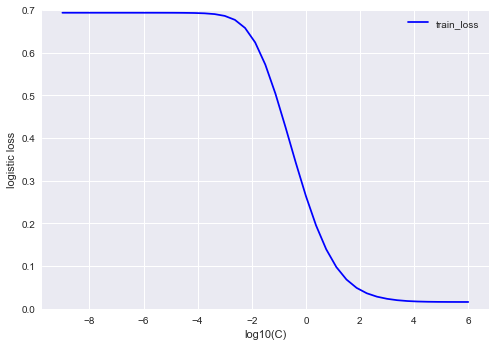

In [81]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Use inverse document frequency 

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIV
tfv = TFIV(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(2,4), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')

X_all = tr_text_list + te_text_list # Combine both to fit the TFIDF vectorization.
tfv.fit(X_all)
X_all = tfv.transform(X_all)

X_tf_train = X_all[:train_len] # Separate back into training and test sets. 
X_tf_test = X_all[train_len:]

In [83]:
tr_loss_list = list()
C_grid = np.logspace(-9, 6, 41)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(X_tf_train, y_tr)
    train_proba = lr.predict_proba(X_tf_train)
    tr_loss_list.append(log_loss(y_tr, train_proba))

idx_min = tr_loss_list.index(min(tr_loss_list))

Best C-value for LR : 1000000.000
Train set log-loss at best C-value: 0.5385


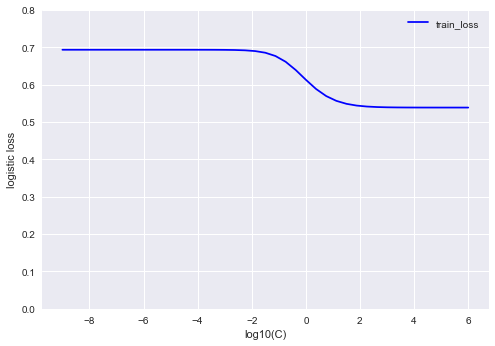

In [84]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.8]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

GridSearchCV  自动调参

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
vect=HashingVectorizer(decode_error='ignore',n_features=2**21,preprocessor=None,tokenizer=tokenizer)
clf=SGDClassifier(loss='log',random_state=1,n_iter=1)

In [ ]:
grid_values = {'C':[30]} # Decide which settings you want for the grid search. 

model_LR = GridSearchCV(LR(penalty = 'L2', dual = True, random_state = 0), 
                        grid_values, scoring = 'roc_auc', cv = 20) 
# Try to set the scoring on what the contest is asking for. 
# The contest says scoring is for area under the ROC curve, so use this.

model_LR.fit(X,y_tr) # Fit the model.

### choose the best hyperparameter and then predict the result

In [ ]:
LR_result = model_LR.predict_proba(X_test)[:,1] 
# We only need the probabilities that the movie review was a 7 or greater. 
LR_output = pd.DataFrame(data={"id":test["id"], "sentiment":LR_result}) 
# Create our dataframe that will be written.
LR_output.to_csv('Logistic_Reg_Proj2.csv', index=False, quoting=3)

In [86]:
x_tr.shape

(2400, 1810)

### Generate a neural network (or MLP) model

In [87]:
n_runs = 16
result_relu = []
def MLP_runs(state):
    start_time_sec = time.time()
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=state,)
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_lbfgs.fit(x_tr, y_tr)
        elapsed_time_sec = time.time() - start_time_sec
        print('finished LBFGS run %2d/%d after %6.1f sec | %3d iters | %s | loss %.3f' % (
            state, n_runs, elapsed_time_sec,len(mlp_lbfgs.loss_curve_),
            'converged   ' if mlp_lbfgs.did_converge else 'NOT converged',
            mlp_lbfgs.loss_))
    return mlp_lbfgs

for i in range(0, n_runs):
        result_relu.append(MLP_runs(i))

finished LBFGS run  0/16 after    1.3 sec | 113 iters | converged    | loss 0.045
finished LBFGS run  1/16 after    1.3 sec | 113 iters | converged    | loss 0.117
finished LBFGS run  2/16 after    1.7 sec | 179 iters | NOT converged | loss 0.029
finished LBFGS run  3/16 after    1.0 sec | 110 iters | converged    | loss 0.075
finished LBFGS run  4/16 after    1.7 sec | 176 iters | NOT converged | loss 0.016
finished LBFGS run  5/16 after    1.7 sec | 144 iters | NOT converged | loss 0.012
finished LBFGS run  6/16 after    1.1 sec |  87 iters | converged    | loss 0.079
finished LBFGS run  7/16 after    1.8 sec | 183 iters | NOT converged | loss 0.025
finished LBFGS run  8/16 after    1.8 sec | 182 iters | NOT converged | loss 0.016
finished LBFGS run  9/16 after    1.4 sec | 128 iters | converged    | loss 0.019
finished LBFGS run 10/16 after    1.8 sec | 186 iters | NOT converged | loss 0.015
finished LBFGS run 11/16 after    0.2 sec |  10 iters | converged    | loss 0.647
finished L

### Generate SVM model

In [94]:
from sklearn import svm

clf = svm.SVC(gamma='scale')
clf.fit(x_tr, y_tr)
ypred = clf.predict(x_te)

ypred.shape

(600,)

In [93]:
ypred

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,